In [1]:
import geopandas as gpd
gpd.__version__

'0.12.0'

In [2]:
import shapely
shapely.__version__

'1.8.5.post1'

# 2 在geopandas解决拓扑错误问题

## 2.1 geopandas中常见的要素拓扑错误情况

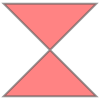

In [3]:
from shapely.geometry import Polygon

# 坐标串自交叉
polygon1 = Polygon([(0, 0), (1, 0), (0, 1), (1, 1)])
polygon1

In [4]:
polygon1.is_valid

False

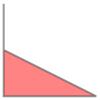

In [5]:
# 边界线存在重叠
polygon2 = Polygon([(0, 2), (0, 1), (2, 0), (0, 0), (0, 2)])
polygon2

In [6]:
polygon2.is_valid

False

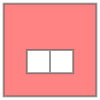

In [7]:
# 内部孔洞之间存在共边
polygon3 = Polygon(
    [(0, 0), (4, 0), (4, 4), (0, 4)],
    [
        [(1, 1), (2, 1), (2, 2), (1, 2)],
        [(2, 1), (3, 1), (3, 2), (2, 2)]
    ]
)
polygon3

In [8]:
polygon3.is_valid

False

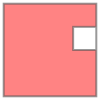

In [9]:
# 内部孔洞与外边界共边
polygon4 = Polygon(
    [(0, 0), (4, 0), (4, 4), (0, 4)],
    [
        [(3, 2), (4, 2), (4, 3), (3, 3)]
    ]
)
polygon4

In [10]:
polygon4.is_valid

False

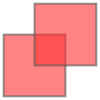

In [11]:
from shapely.geometry import MultiPolygon

# 多部件面要素之间存在重叠
multi_polygon1 = MultiPolygon(
    [
        Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]),
        Polygon([(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)])
    ]
)
multi_polygon1

In [12]:
multi_polygon1.is_valid

False

## 2.2 对拓扑错误要素进行诊断

In [13]:
# 将上述的所有矢量写出
(
    gpd
    .GeoDataFrame({
        'geometry': [polygon1, polygon2, polygon3, polygon4, multi_polygon1],
        'id': range(1, 6)
    })
    .to_file('demo.shp')
)

In [14]:
# 读入刚刚写出的shp文件
demo_gdf = gpd.read_file('./demo.shp')
demo_gdf

,id,geometry
0,1,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 0...."
1,2,"POLYGON ((0.00000 2.00000, 0.00000 1.00000, 2...."
2,3,"POLYGON ((0.00000 0.00000, 0.00000 4.00000, 4...."
3,4,"POLYGON ((0.00000 0.00000, 0.00000 4.00000, 4...."
4,5,"MULTIPOLYGON (((0.00000 0.00000, 0.00000 1.000..."


In [15]:
demo_gdf.is_valid

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [16]:
from shapely.validation import explain_validity

# 批量拓扑诊断
demo_gdf.geometry.map(explain_validity)

0     Self-intersection[0.5 0.5]
1    Ring Self-intersection[0 1]
2         Self-intersection[2 2]
3         Self-intersection[4 2]
4       Self-intersection[0.5 1]
Name: geometry, dtype: object

## 2.3 对拓扑问题进行修复

In [17]:
# geopandas >= 0.12.0版本
demo_gdf.geometry.make_valid().is_valid

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [18]:
from shapely.validation import make_valid

# geopandas < 0.12.0版本
demo_gdf.geometry.map(make_valid).is_valid

0    True
1    True
2    True
3    True
4    True
dtype: bool

- 修复错误情况1：**坐标串自交叉**

In [19]:
fixed_demo_gdf = demo_gdf.copy()
fixed_demo_gdf.geometry = fixed_demo_gdf.geometry.make_valid()

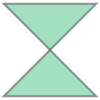

In [20]:
fixed_demo_gdf.at[0, 'geometry']

In [21]:
type(fixed_demo_gdf.at[0, 'geometry'])

shapely.geometry.multipolygon.MultiPolygon

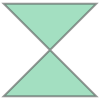

In [22]:
fixed_demo_gdf.at[0, 'geometry'].buffer(1 / 1000000)

In [23]:
type(fixed_demo_gdf.at[0, 'geometry'].buffer(1 / 1000000))

shapely.geometry.polygon.Polygon

- 修复错误情况2：**边界线存在重叠**

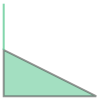

In [24]:
fixed_demo_gdf.at[1, 'geometry']

In [25]:
type(fixed_demo_gdf.at[1, 'geometry'])

shapely.geometry.collection.GeometryCollection

In [26]:
list(fixed_demo_gdf.at[1, 'geometry'].geoms)

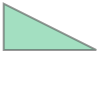

In [27]:
from shapely.ops import unary_union

unary_union(
    [g for g in fixed_demo_gdf.at[1, 'geometry'].geoms 
     if 'Polygon' in g.geom_type]
)

- 修复错误情况3：**内部孔洞之间存在共边**

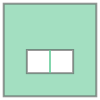

In [28]:
fixed_demo_gdf.at[2, 'geometry']

In [29]:
type(fixed_demo_gdf.at[2, 'geometry'])

shapely.geometry.collection.GeometryCollection

In [30]:
list(fixed_demo_gdf.at[2, 'geometry'].geoms)

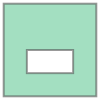

In [31]:
list(fixed_demo_gdf.at[2, 'geometry'].geoms)[0]

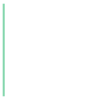

In [32]:
list(fixed_demo_gdf.at[2, 'geometry'].geoms)[1]

- 修复错误情况4：**内部孔洞与外边界共边**

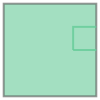

In [33]:
fixed_demo_gdf.at[3, 'geometry']

In [34]:
type(fixed_demo_gdf.at[3, 'geometry'])

shapely.geometry.collection.GeometryCollection

In [35]:
list(fixed_demo_gdf.at[3, 'geometry'].geoms)

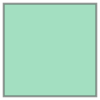

In [36]:
list(fixed_demo_gdf.at[3, 'geometry'].geoms)[0]

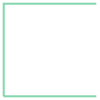

In [37]:
list(fixed_demo_gdf.at[3, 'geometry'].geoms)[1]

- 修复错误情况5：**多部件面要素之间存在重叠**

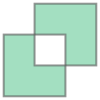

In [38]:
fixed_demo_gdf.at[4, 'geometry']

In [39]:
type(fixed_demo_gdf.at[4, 'geometry'])

shapely.geometry.multipolygon.MultiPolygon

In [40]:
list(fixed_demo_gdf.at[4, 'geometry'].geoms)

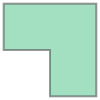

In [41]:
fixed_demo_gdf.at[4, 'geometry'].geoms[0]

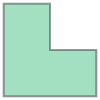

In [42]:
fixed_demo_gdf.at[4, 'geometry'].geoms[1]